# Run GWR and SEM

Note:  used R implementation for mxGWR (gwr_r). 

follow; https://deepnote.com/app/carlos-mendez/PYTHON-GWR-and-MGWR-71dd8ba9-a3ea-4d28-9b20-41cc8a282b7a

In [ ]:
!pip install -U mgwr==2.2.1
!pip install pandas==2.2.2
!pip install numpy==1.23.5
!pip install scanpy==1.10.3
!pip install tqdm

!pip install anndata==0.10.8
!pip install pysal==24.1


In [ ]:
from shapely.geometry import Point
import scanpy as sc
import anndata
# Check for NaN values
from statsmodels.stats.outliers_influence import variance_inflation_factor
import libpysal
from pysal.lib import weights
import seaborn as sns
from pysal.model import spreg
import pandas as pd
import numpy as np
import geopandas as gpd
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import matplotlib.pyplot as plt
from scipy.stats import norm

In [ ]:
#read in X_pca_df; df with TME and CNV principal components
X_pca_df = pd.read_csv("results/xenium_regression_df.csv",index_col=0)


Adjust the dataframe for regression; different steps depending on what variables we want to include in the regression analysis

In [ ]:
#read in xenium_aligned_ductal_invasive
#filter for where Cluster contains DCIS
#X_pca_df = X_pca_df[X_pca_df['Cluster'].str.contains("DCIS")]
#X_pca_df = X_pca_df[X_pca_df['Cluster'].str.contains("DCIS")]
#X_pca_df = X_pca_df[X_pca_df['Cluster'].str.contains("Prolif_Invasive_Tumor")]

# Switch the sign of columns that start with "min"
X_pca_df.loc[:, X_pca_df.columns.str.startswith('min')] *= -1

# Normalize columns that start with "min"
X_pca_df.loc[:, X_pca_df.columns.str.startswith('min')] = (
    X_pca_df.loc[:, X_pca_df.columns.str.startswith('min')].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
)

# Normalize columns that start with "PC"
X_pca_df.loc[:, X_pca_df.columns.str.startswith('PC')] = (
    X_pca_df.loc[:, X_pca_df.columns.str.startswith('PC')].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
)
top_cells = [col for col in X_pca_df.columns if col.startswith('min') or col.startswith('PC')]
#add "Cluster" to top_cells if we want to regress this variable
#top_cells.append("Cluster")
#remove high colinearity variables
top_cells = [col for col in top_cells if col != "PC2" and col != "min_distance_to_Endothelial.RGS5" and col != "min_distance_to_CAFs.MSC.iCAF.like"]

#remove all PC columns if we want to regress out just TME
top_cells = [col for col in top_cells if not col.startswith('PC')]
#remove all min columns if we want to regress just principal components
#top_cells = [col for col in top_cells if not col.startswith('min')]
X_pca_df_filtered = X_pca_df[top_cells]

#convert Cluster to category if we are regressing out the cluster variable
#X_pca_df_filtered = pd.get_dummies(X_pca_df_filtered, columns=['Cluster'], drop_first=True)
#if column has cluster in it, conver to int dtype
#for col in X_pca_df_filtered.columns:
#    if "Cluster" in col:
#        X_pca_df_filtered[col] = X_pca_df_filtered[col].astype(int)


<Axes: >

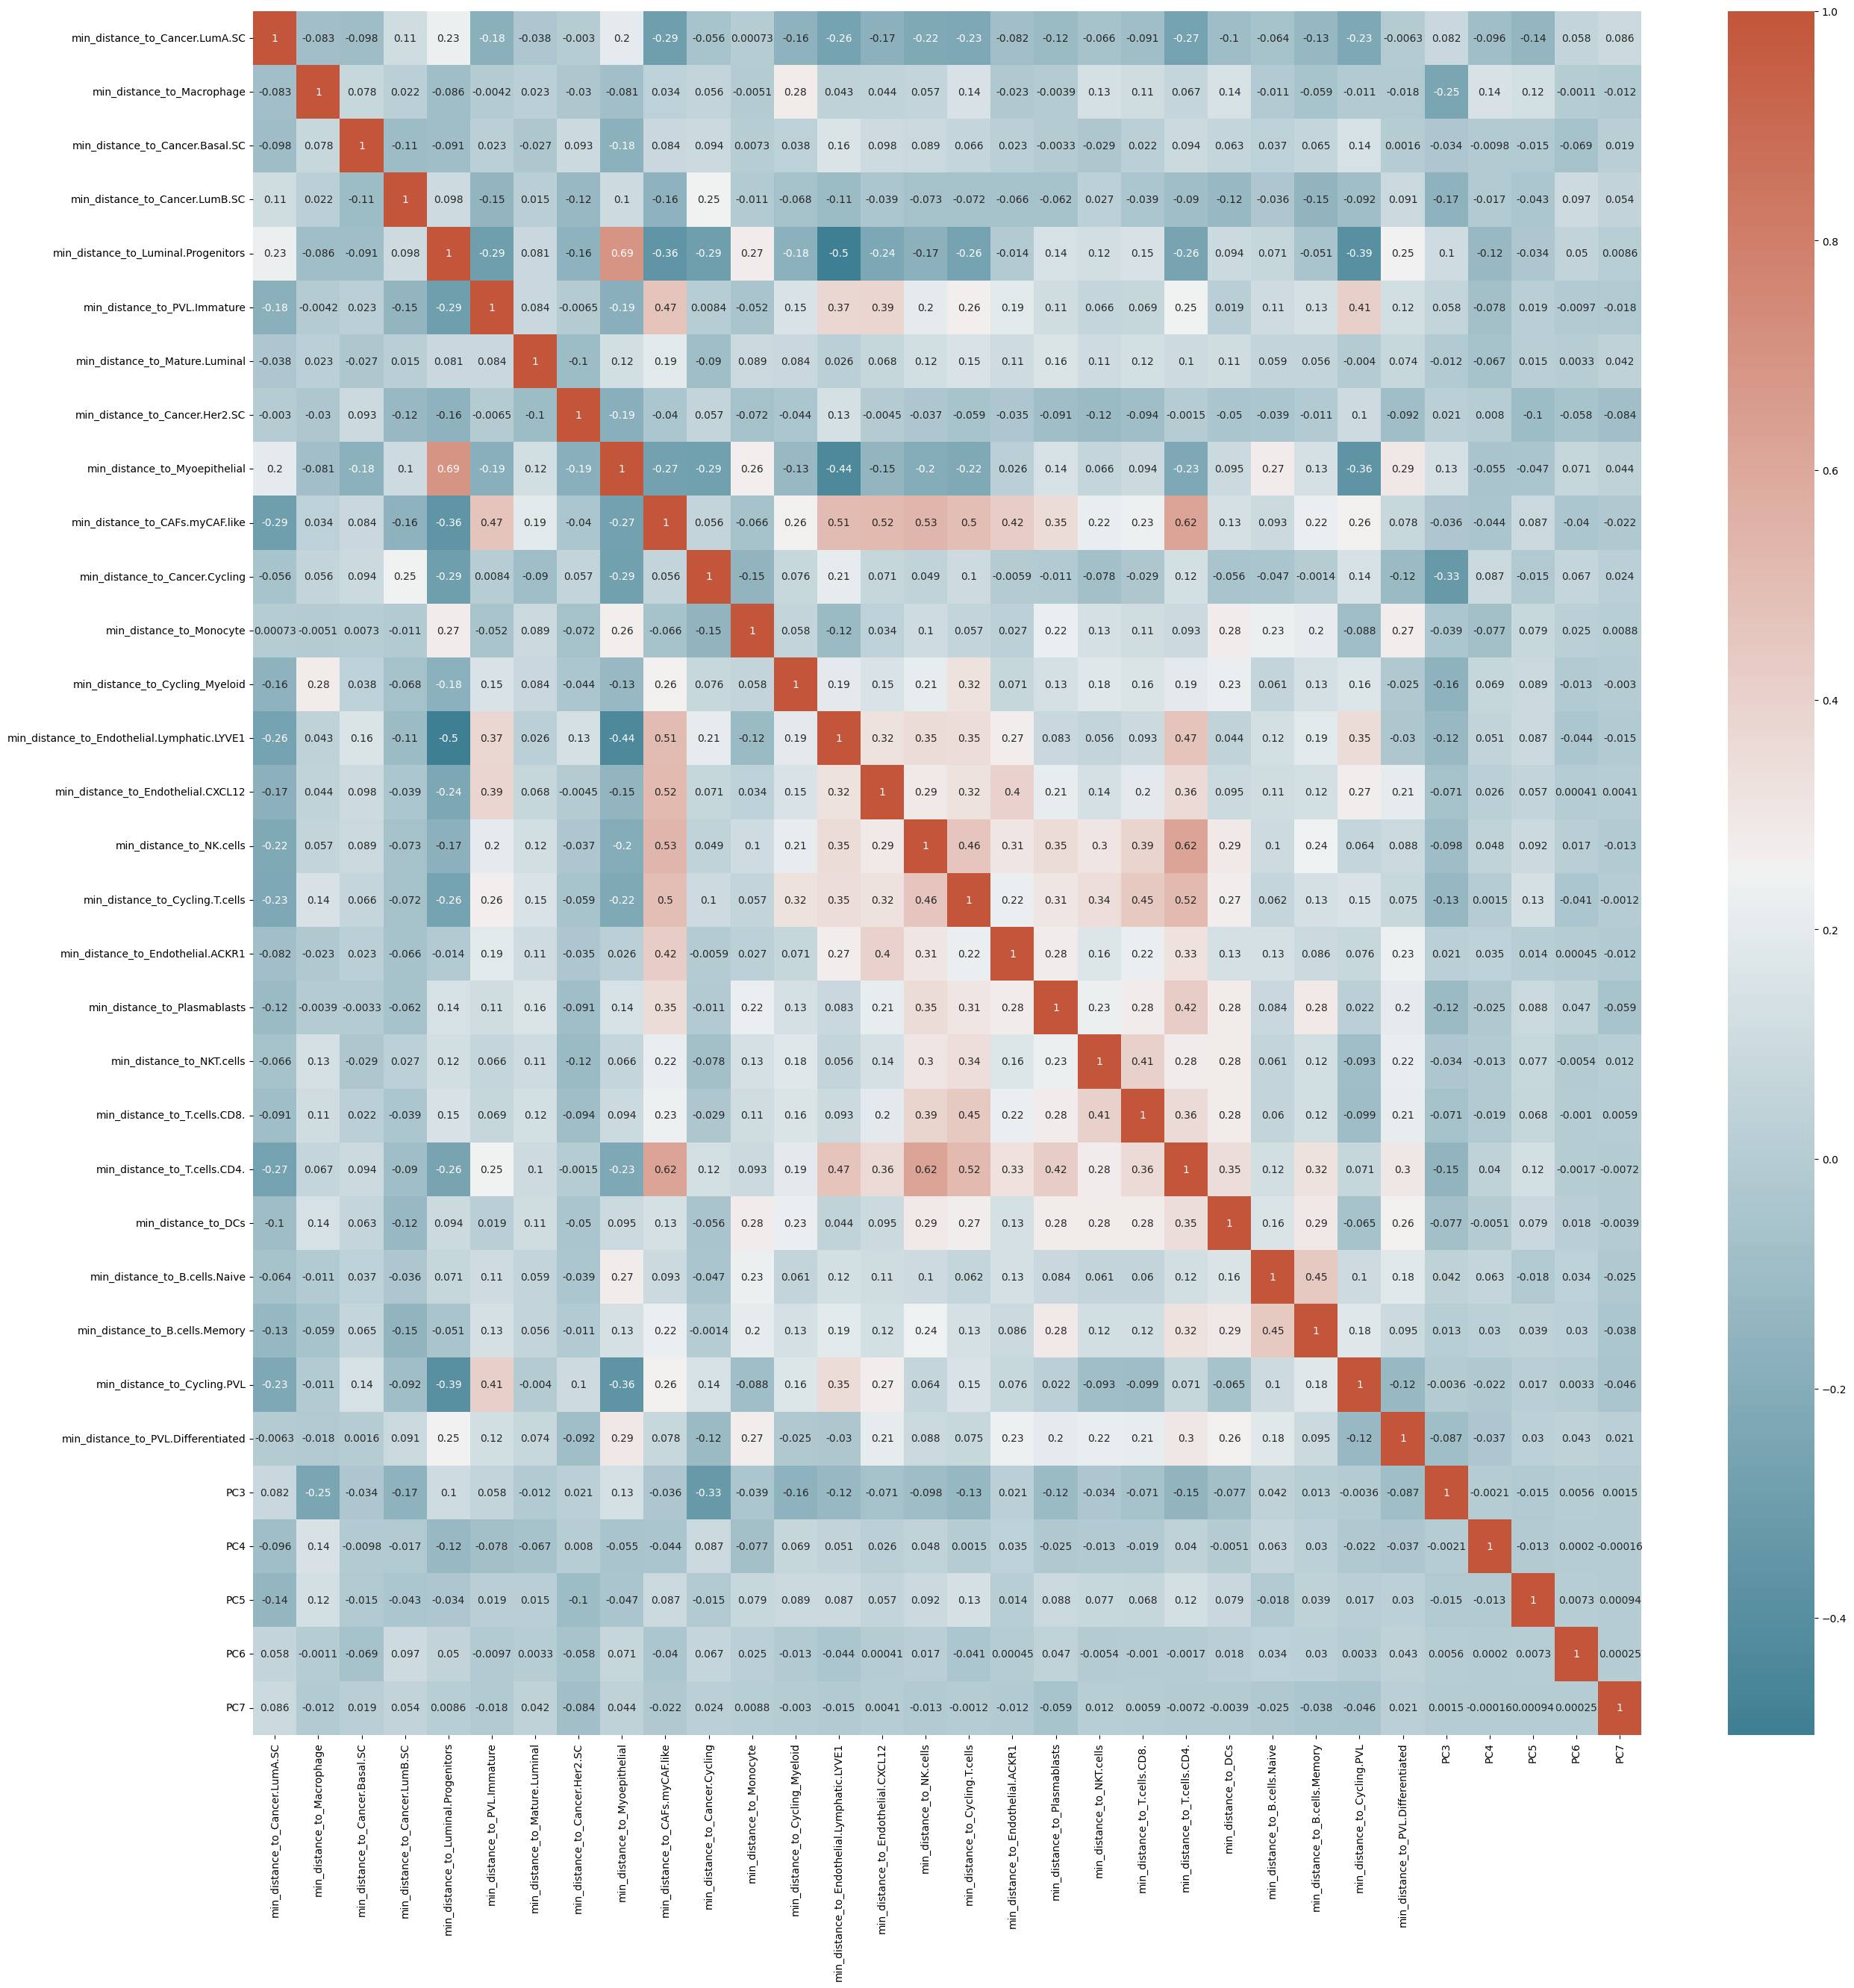

In [ ]:
#calculate correlation matrix; check highly correlated variables
corr = X_pca_df_filtered.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [ ]:
#save X_pca_df
X_pca_df_filtered.to_csv("results/xenium_regression_df_filtered_all.csv")
#X_pca_df.to_csv("results/regression_df_proccessed_just_DCIS.csv")


In [28]:

filtered_df_x = X_pca_df_filtered.to_numpy()
u = X_pca_df['array_row'].values
v = X_pca_df['array_col'].values
coords = list(zip(u, v))
y=X_pca_df['EMT_hallmarks'].values.reshape(-1,1)


In [ ]:
gwr_selector = Sel_BW(coords, y, filtered_df_x).search(bw_min=2)
print(f"Optimal bandwidth: {gwr_selector}")
gwr_results = GWR(coords, y, filtered_df_x, gwr_selector).fit()


In [ ]:
print(gwr_results.summary())

Model type                                                         Gaussian
Number of observations:                                               14759
Number of covariates:                                                    28

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             22.985
Log-likelihood:                                                   26764.741
AIC:                                                             -53473.482
AICc:                                                            -53471.363
BIC:                                                            -141388.846
R2:                                                                   0.169
Adj. R2:                                                              0.167

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

Now run the SEM

In [ ]:
import numpy as np
from libpysal.weights import Queen
from spreg import ML_Error
import pandas as pd
from libpysal.weights import KNN


# Assuming `coords` is a numpy array of coordinates (n_samples, 2)
w = KNN.from_array(coords, k=4)  
w.transform = 'r'
# 2. Prepare predictor and dependent variables
X = np.array(filtered_df_x)  # Convert predictors to array format
y = np.array(y).reshape(-1, 1)  # Reshape dependent variable to a column vector

# 3. Fit the Spatial Error Model
sem_model = ML_Error(y, X, w=w)

# Print results
print(sem_model.summary)


/home/eloise/miniconda3/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 160 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/home/eloise/miniconda3/lib/python3.12/site-packages/spreg/ml_error.py:183: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


In [195]:
#get attributes of sem_model
residuals = sem_model.u  # The residuals are stored in `sem_model.u`
#save residuals
np.save("results/residuals_sem_dcis.npy", residuals)

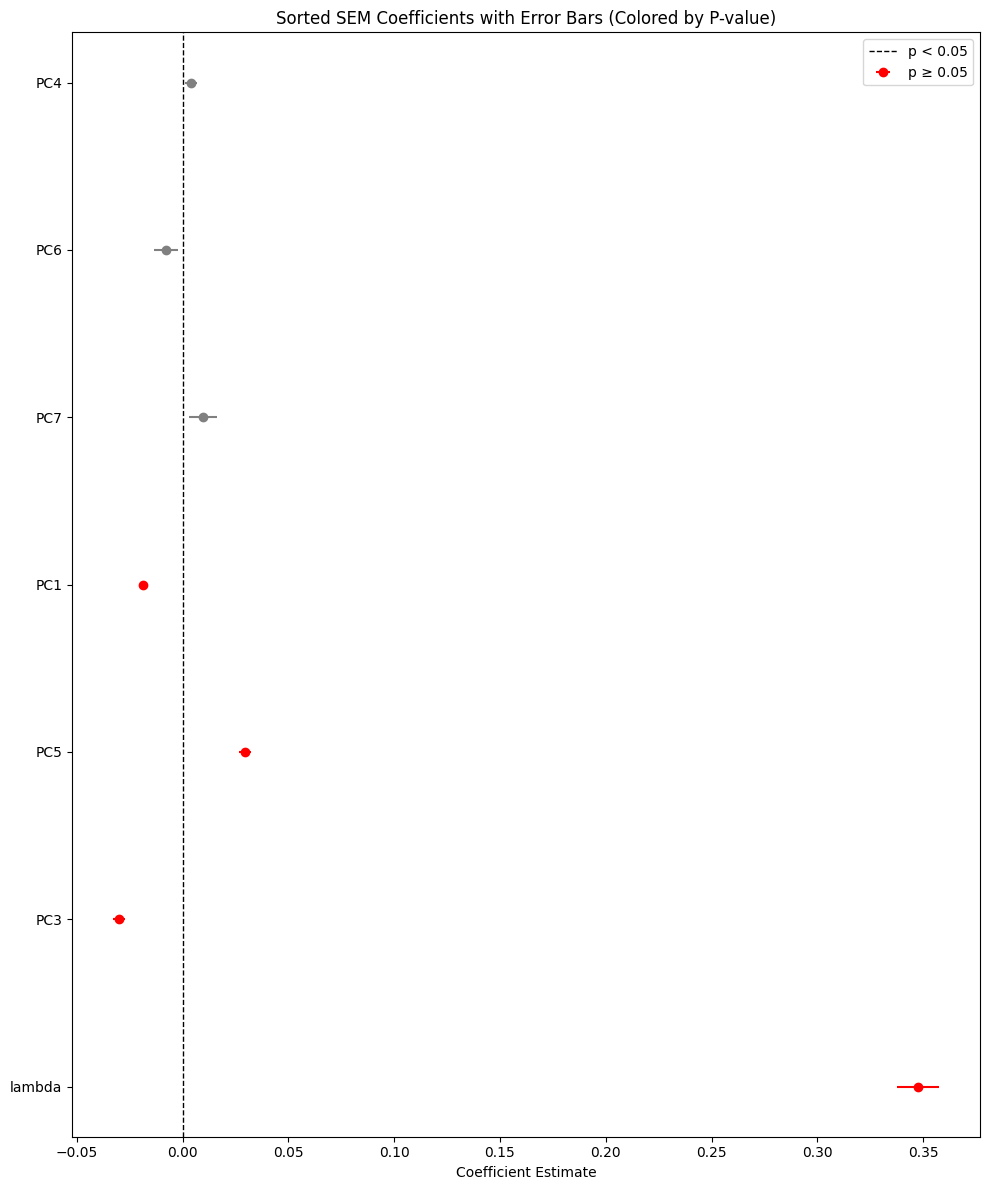

In [ ]:


# Define predictor labels excluding CONSTANT and lambda
predictor_labels = list(X_pca_df_filtered.columns)
#add lambda
predictor_labels.append("lambda")
# Extract coefficients, standard errors, and calculate z-scores excluding CONSTANT and lambda
coefficients = sem_model.betas.flatten()[1:]  # Exclude intercept and lambda
std_errors = sem_model.std_err.flatten()[1:]  # Exclude intercept and lambda

# Calculate p-values from z-scores
z_scores = coefficients / std_errors
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

# Verify length alignment
if len(predictor_labels) != len(coefficients):
    raise ValueError(f"Mismatch: {len(predictor_labels)} labels vs. {len(coefficients)} coefficients.")

# Sort coefficients by absolute value
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_labels = [predictor_labels[i] for i in sorted_indices]
sorted_coefficients = coefficients[sorted_indices]
sorted_std_errors = std_errors[sorted_indices]
sorted_p_values = p_values[sorted_indices]

# Define colors based on p-values
colors = ['red' if p < 0.05 else 'grey' for p in sorted_p_values]

# Plot with correctly ordered labels on the y-axis
plt.figure(figsize=(10, 12))
for i, (label, coef, std, color) in enumerate(zip(sorted_labels, sorted_coefficients, sorted_std_errors, colors)):
    plt.errorbar(coef, i, xerr=std, fmt='o', color=color, label='p < 0.05' if color == 'red' else 'p ≥ 0.05')
# Add a vertical line at zero
plt.axvline(0, color='black', linestyle='--', linewidth=1)

# Customize plot
plt.yticks(range(len(sorted_labels)), sorted_labels)
plt.xlabel("Coefficient Estimate")
plt.title("Sorted SEM Coefficients with Error Bars (Colored by P-value)")
plt.legend(['p < 0.05', 'p ≥ 0.05'], loc='upper right')
plt.tight_layout()
#save to final_results
plt.savefig("results/final_results/sem_coefficients.pdf")
plt.show()



In [ ]:
import numpy as np
import pandas as pd
import pickle

# Define paths for saving
gwr_path = "gwr_results_All.pkl"

# Save GWR results
gwr_results_data = {
    'params': gwr_results.params,  # GWR coefficient surfaces
    'tvalues': gwr_results.tvalues,  # GWR t-values
    'pvalues': gwr_results.pvalues  # GWR p-values
}



# Save min/max values for color scale standardization
param_mins = np.min([gwr_results.params.min(), gwr_results.params.min()], axis=0)
param_maxs = np.max([gwr_results.params.max(), gwr_results.params.max()], axis=0)
scale_info = {'vmin': param_mins, 'vmax': param_maxs}

# Save all data
with open(gwr_path, 'wb') as f:
    pickle.dump({'gwr': gwr_results_data, 'scale_info': scale_info}, f)

